In [6]:
! ls -l --block-size=MB

total 2596MB
-rw-rw-r-- 1 redanalyze redanalyze    1MB Jul  1 02:01 'BERT - TF Keras implementation - Sentiment Analysis-Copy1.ipynb'
-rw-rw-r-- 1 redanalyze redanalyze    1MB Jul  1 02:00 'BERT - TF Keras implementation - Sentiment Analysis.ipynb'
-rw-rw-r-- 1 redanalyze redanalyze    1MB Jun 21 13:11 'BERT Inference - TF Implementation - Sentiment Analysis.ipynb'
-rw-rw-r-- 1 redanalyze redanalyze    1MB Jun 21 13:11 'BERT Training - TF Implementation - Sentiment Analysis.ipynb'
-rw-rw-r-- 1 redanalyze redanalyze 1320MB Jun 25 08:12  bert_sentiment_model.h5
-rw-rw-r-- 1 redanalyze redanalyze  442MB Jun 25 08:12  bert_sentiment_model_weights.h5
-rw-rw-r-- 1 redanalyze redanalyze    1MB Jun 21 11:18  checkpoint
drwxr-xr-x 2 redanalyze redanalyze    1MB Jun 21 10:02  eval
-rw-rw-r-- 1 redanalyze redanalyze  623MB Jun 21 11:18  events.out.tfevents.1561110216.better-eve-instance
-rw-rw-r-- 1 redanalyze redanalyze  193MB Jun 21 11:01  graph.pbtxt
-rw-rw-r-- 1 redanalyze redanalyze   20MB J

In [7]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as tf_hub
import time
import numpy as np
import os
from bert.tokenization import FullTokenizer
from tqdm import tqdm_notebook
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
tf.logging.set_verbosity(tf.logging.INFO)
SEED = 42
np.random.seed(SEED)
tf.set_random_seed(SEED)

%matplotlib inline

In [8]:
print(tf.__version__)
print(tf_hub.__version__)

1.12.0
0.4.0


In [9]:
print(tf.test.is_gpu_available())
print(tf.test.gpu_device_name())

True
/device:GPU:0


In [10]:
! nvidia-smi

Mon Jul  1 02:02:31 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    30W /  70W |    213MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [11]:
dataset = pd.read_csv('./imdb_movie_reviews.csv.bz2', compression='bz2')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.3+ KB


In [12]:
dataset['sentiment'] = [1 if sentiment == 'positive' else 0 
                            for sentiment in dataset['sentiment'].values]
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [13]:
train_df = dataset.iloc[:30000]
val_df = dataset.iloc[30000:35000]
test_df = dataset.iloc[35000:]

train_df.shape, val_df.shape, test_df.shape

((30000, 2), (5000, 2), (15000, 2))

In [14]:
train_text = train_df['review'].tolist()
train_labels = train_df['sentiment'].tolist()

val_text = val_df['review'].tolist()
val_labels = val_df['sentiment'].tolist()

test_text = test_df['review'].tolist()
test_labels = test_df['sentiment'].tolist()

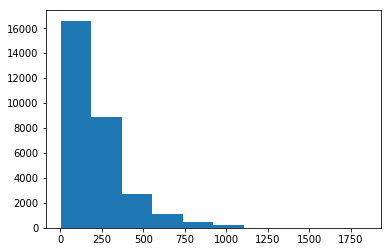

In [62]:
train_doc_lens = [len(doc.split(' ')) for doc in train_text]
o = plt.hist(train_doc_lens)

In [15]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
       When running eval/predict on the TPU, we need to pad the number of examples
       to be a multiple of the batch size, because the TPU requires a fixed batch
       size. The alternative is to drop the last batch, which is bad because it means
       the entire output data won't be generated.
       We use this class instead of `None` because treating `None` as padding
       batches could cause silent errors.
  """
    
    
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [16]:
def create_tokenizer_from_hub_module(bert_path):
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  tf_hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

In [17]:
def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=text, text_b=None, label=label)
        )
    return InputExamples

In [18]:
def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

In [19]:
# Initialize session
sess = tf.Session()

# Params for bert model and tokenization
BERT_PATH = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
MAX_SEQ_LENGTH = 512

In [20]:
# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module(bert_path=BERT_PATH)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0701 02:02:46.433641 140267069904704 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


In [21]:
# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, train_labels)
val_examples = convert_text_to_examples(val_text, val_labels)
test_examples = convert_text_to_examples(test_text, test_labels)

In [22]:
(train_input_ids, train_input_masks, 
 train_segment_ids, train_labels) =  convert_examples_to_features(tokenizer=tokenizer, 
                                                                  examples=train_examples, 
                                                                  max_seq_length=MAX_SEQ_LENGTH)

(val_input_ids, val_input_masks, 
 val_segment_ids, val_labels) =  convert_examples_to_features(tokenizer=tokenizer, 
                                                              examples=val_examples, 
                                                              max_seq_length=MAX_SEQ_LENGTH)

(test_input_ids, test_input_masks, 
 test_segment_ids, test_labels) =  convert_examples_to_features(tokenizer=tokenizer, 
                                                                examples=test_examples, 
                                                                max_seq_length=MAX_SEQ_LENGTH)

In [23]:
train_input_ids.shape, val_input_ids.shape, test_input_ids.shape

((30000, 512), (5000, 512), (15000, 512))

In [24]:
bm = tf_hub.Module(BERT_PATH, trainable=True, name=f"bert_module")
bm

In [25]:
for var in bm.variables:
    print(var)
    print(var.name)
    print('\t\t|')
    print('\t\tV')

<tf.Variable 'bert_module/bert/embeddings/LayerNorm/beta:0' shape=(768,) dtype=float32>
bert_module/bert/embeddings/LayerNorm/beta:0
		|
		V
<tf.Variable 'bert_module/bert/embeddings/LayerNorm/gamma:0' shape=(768,) dtype=float32>
bert_module/bert/embeddings/LayerNorm/gamma:0
		|
		V
<tf.Variable 'bert_module/bert/embeddings/position_embeddings:0' shape=(512, 768) dtype=float32>
bert_module/bert/embeddings/position_embeddings:0
		|
		V
<tf.Variable 'bert_module/bert/embeddings/token_type_embeddings:0' shape=(2, 768) dtype=float32>
bert_module/bert/embeddings/token_type_embeddings:0
		|
		V
<tf.Variable 'bert_module/bert/embeddings/word_embeddings:0' shape=(30522, 768) dtype=float32>
bert_module/bert/embeddings/word_embeddings:0
		|
		V
<tf.Variable 'bert_module/bert/encoder/layer_0/attention/output/LayerNorm/beta:0' shape=(768,) dtype=float32>
bert_module/bert/encoder/layer_0/attention/output/LayerNorm/beta:0
		|
		V
<tf.Variable 'bert_module/bert/encoder/layer_0/attention/output/LayerN

In [26]:
len(bm.variables)

204

In [27]:
for i in range(10+1):
    print(f"encoder/layer_{str(10 - i)}")

encoder/layer_10
encoder/layer_9
encoder/layer_8
encoder/layer_7
encoder/layer_6
encoder/layer_5
encoder/layer_4
encoder/layer_3
encoder/layer_2
encoder/layer_1
encoder/layer_0


In [28]:
class BertLayer(tf.layers.Layer):
    
    def __init__(self, bert_path, n_fine_tune_encoders=10, **kwargs,):
        
        self.n_fine_tune_encoders = n_fine_tune_encoders
        self.trainable = True
        self.output_size = 768
        self.bert_path = bert_path
        super(BertLayer, self).__init__(**kwargs)

        
    def build(self, input_shape):
        self.bert = tf_hub.Module(self.bert_path,
                                  trainable=self.trainable, 
                                  name=f"{self.name}_module")

        # Remove unused layers
        trainable_vars = self.bert.variables
        trainable_vars = [var for var in trainable_vars 
                                  if not "/cls/" in var.name]
        trainable_layers = ["embeddings", "pooler/dense"]


        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_encoders+1):
            trainable_layers.append(f"encoder/layer_{str(10 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [var for var in trainable_vars
                                  if any([l in var.name 
                                              for l in trainable_layers])]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:# and 'encoder/layer' not in var.name:
                self._non_trainable_weights.append(var)
        print('Trainable layers:', len(self._trainable_weights))
        print('Non Trainable layers:', len(self._non_trainable_weights))

        super(BertLayer, self).build(input_shape)

        
    def call(self, inputs):
        
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(input_ids=input_ids, 
                           input_mask=input_mask, 
                           segment_ids=segment_ids)
        
        pooled = self.bert(inputs=bert_inputs, 
                           signature="tokens", 
                           as_dict=True)["pooled_output"]

        return pooled

    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size) 

In [29]:
# Build model
def build_model(bert_path, max_seq_length, n_fine_tune_encoders=10): 
    
    inp_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    inp_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    inp_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [inp_id, inp_mask, inp_segment]
    
    bert_output = BertLayer(bert_path=bert_path, 
                            n_fine_tune_encoders=n_fine_tune_encoders)(bert_inputs)
    
    dense = tf.keras.layers.Dense(256, activation='relu')(bert_output)
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(lr=2e-5), 
                  metrics=['accuracy'])    
    return model

In [30]:
def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [31]:
MAX_SEQ_LENGTH

512

In [32]:
model = build_model(bert_path=BERT_PATH, max_seq_length=MAX_SEQ_LENGTH, n_fine_tune_encoders=10)

# Instantiate variables
initialize_vars(sess)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0701 02:06:06.637487 140267069904704 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Trainable layers: 199
Non Trainable layers: 5
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0701 02:06:08.384334 140267069904704 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


In [34]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          (None, 512)          0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        (None, 512)          0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        (None, 512)          0                                            
__________________________________________________________________________________________________
bert_layer_1 (BertLayer)        (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]                
          

In [35]:
model.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([val_input_ids, val_input_masks, val_segment_ids], val_labels),
    epochs=3,
    batch_size=15,
    verbose=1
)

/home/redanalyze/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 30000 samples, validate on 5000 samples
Epoch 1/3
30000/30000 [==============================] - 4427s 148ms/step - loss: 0.2086 - acc: 0.9178 - val_loss: 0.1599 - val_acc: 0.9370
Epoch 2/3
30000/30000 [==============================] - 4413s 147ms/step - loss: 0.0809 - acc: 0.9732 - val_loss: 0.1916 - val_acc: 0.9322
Epoch 3/3
 3570/30000 [==>...........................] - ETA: 1:01:08 - loss: 0.0259 - acc: 0.9927

KeyboardInterrupt: 

In [38]:
test_predictions = model.predict(x=[test_input_ids, 
                                    test_input_masks, 
                                    test_segment_ids],
                                 batch_size=200,
                                 verbose=1)

15000/15000 [==============================] - 802s 53ms/step


In [39]:
test_predictions = test_predictions.ravel()

In [40]:
test_pred_labels = [1 if prob > 0.5 else 0 for prob in test_predictions]

In [41]:
from sklearn.metrics import confusion_matrix, classification_report

print('Classification Report:')
print(classification_report(y_true=test_labels, y_pred=test_pred_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7490
           1       0.95      0.93      0.94      7510

    accuracy                           0.94     15000
   macro avg       0.94      0.94      0.94     15000
weighted avg       0.94      0.94      0.94     15000



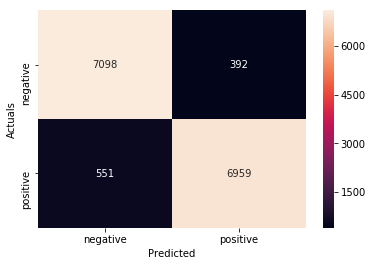

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

with tf.Session() as session:
    cm = tf.confusion_matrix(test_labels, test_pred_labels).eval()

LABELS = ['negative', 'positive']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")

In [43]:
model.save_weights('bert_sentiment_model_weights_seq512b15.h5')

In [44]:
model.save('bert_sentiment_model_seq512b15.h5')

In [45]:
! ls -l --block-size=MB

total 4357MB
-rw-rw-r-- 1 redanalyze redanalyze    1MB Jul  1 04:57 'BERT - TF Keras implementation - Sentiment Analysis-Copy1.ipynb'
-rw-rw-r-- 1 redanalyze redanalyze    1MB Jul  1 02:00 'BERT - TF Keras implementation - Sentiment Analysis.ipynb'
-rw-rw-r-- 1 redanalyze redanalyze    1MB Jun 21 13:11 'BERT Inference - TF Implementation - Sentiment Analysis.ipynb'
-rw-rw-r-- 1 redanalyze redanalyze    1MB Jun 21 13:11 'BERT Training - TF Implementation - Sentiment Analysis.ipynb'
-rw-rw-r-- 1 redanalyze redanalyze 1320MB Jun 25 08:12  bert_sentiment_model.h5
-rw-rw-r-- 1 redanalyze redanalyze 1320MB Jul  1 04:57  bert_sentiment_model_seq512b15.h5
-rw-rw-r-- 1 redanalyze redanalyze  442MB Jun 25 08:12  bert_sentiment_model_weights.h5
-rw-rw-r-- 1 redanalyze redanalyze  442MB Jul  1 04:57  bert_sentiment_model_weights_seq512b15.h5
-rw-rw-r-- 1 redanalyze redanalyze    1MB Jun 21 11:18  checkpoint
drwxr-xr-x 2 redanalyze redanalyze    1MB Jun 21 10:02  eval
-rw-rw-r-- 1 redanalyze redana

In [46]:
model = None
model = build_model(bert_path=BERT_PATH, max_seq_length=MAX_SEQ_LENGTH, n_fine_tune_encoders=10)
initialize_vars(sess)
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0701 04:57:47.784232 140267069904704 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Trainable layers: 199
Non Trainable layers: 5
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0701 04:57:49.445465 140267069904704 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          (None, 512)          0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        (None, 512)          0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        (None, 512)          0                                            
__________________________________________________________________________________________________
bert_layer_2 (BertLayer)        (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]                
          

In [47]:
test_predictions = model.predict(x=[test_input_ids, 
                                    test_input_masks, 
                                    test_segment_ids],
                                 batch_size=200,
                                 verbose=1)

15000/15000 [==============================] - 811s 54ms/step


In [48]:
test_predictions = test_predictions.ravel()
test_pred_labels = [1 if prob > 0.5 else 0 for prob in test_predictions]

In [49]:
print('Classification Report:')
print(classification_report(y_true=test_labels, y_pred=test_pred_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      7490
           1       0.50      0.00      0.00      7510

    accuracy                           0.50     15000
   macro avg       0.50      0.50      0.33     15000
weighted avg       0.50      0.50      0.33     15000



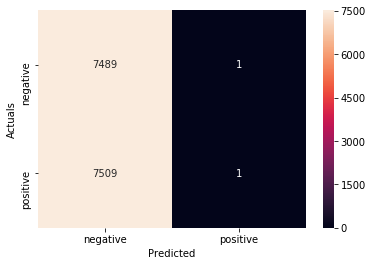

In [50]:
with tf.Session() as session:
    cm = tf.confusion_matrix(test_labels, test_pred_labels).eval()

LABELS = ['negative', 'positive']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")

In [51]:
model.load_weights('bert_sentiment_model_weights_seq512b15.h5')

In [52]:
test_predictions = model.predict(x=[test_input_ids, 
                                    test_input_masks, 
                                    test_segment_ids],
                                 batch_size=200,
                                 verbose=1)

15000/15000 [==============================] - 808s 54ms/step


In [53]:
test_predictions = test_predictions.ravel()
test_pred_labels = [1 if prob > 0.5 else 0 for prob in test_predictions]

In [54]:
print('Classification Report:')
print(classification_report(y_true=test_labels, y_pred=test_pred_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7490
           1       0.95      0.93      0.94      7510

    accuracy                           0.94     15000
   macro avg       0.94      0.94      0.94     15000
weighted avg       0.94      0.94      0.94     15000



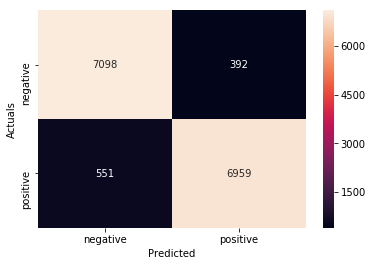

In [55]:
with tf.Session() as session:
    cm = tf.confusion_matrix(test_labels, test_pred_labels).eval()

LABELS = ['negative', 'positive']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")